In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift,ifftshift,ifft2

# Helper Functions

In [2]:
def fourier_transform(image):
    if len(image.shape) == 3:
        image = np.mean(image, axis=-1)

    # Perform 2D Fourier Transform
    fft_result = fft2(image)

    # Shift zero frequency components to the center
    fft_result_shifted = fftshift(fft_result)

    # Calculate the magnitude spectrum (log scale for better visualization)
    magnitude_spectrum = np.log(np.abs(fft_result_shifted) + 1)

    return magnitude_spectrum,fft_result_shifted

def inverse_fourier(fft_result_shifted):
    # Inverse shift to prepare for inverse Fourier transform
    fft_result_unshifted_masked = ifftshift(fft_result_shifted)
    # Inverse Fourier Transform
    original_filtered = np.abs(ifft2(fft_result_unshifted_masked))
    return original_filtered


def add_rotation(angle, image):
    # Define the rotation angle (in degrees)

    # Get the center of the image
    height, width = image.shape[:2]
    center = (width / 2, height / 2)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

def add_translation(shift_x, shift_y, image):
    # Define the rotation angle (in degrees)

    height, width = image.shape[:2]

    # Define the translation matrix
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Apply the translation to the rotated image
    shifted_image = cv2.warpAffine(image, translation_matrix, (width, height))

    return shifted_image
        

# Loading Images

In [3]:
image = plt.imread('F:\FYP\FYP\MRART_png_scans\scan_000103\standard_000103_png.png')
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

magnitude_spectrum,fft_result_shifted = fourier_transform(image)

rotated_image = add_translation(1,0,image)
rotated_magnitude_spectrum,rotated_fft_result_shifted = fourier_transform(rotated_image)

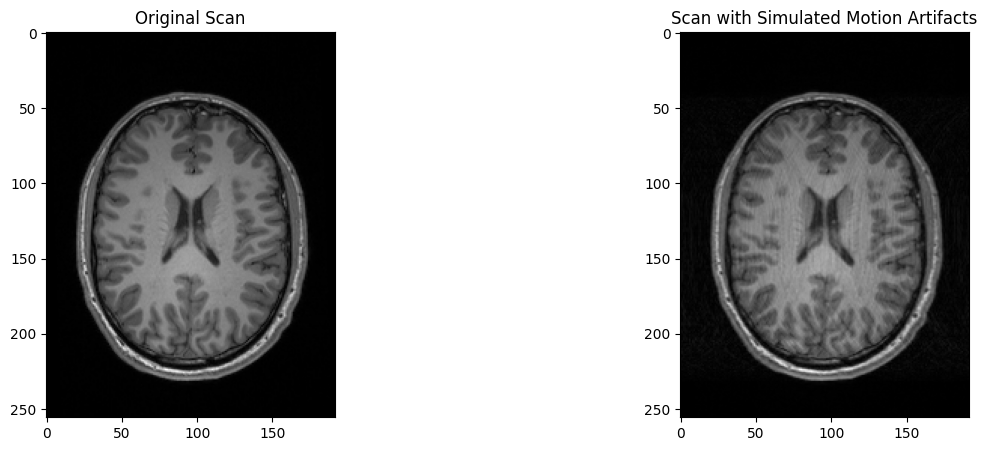

In [4]:
number_of_lines = 100 # Define the number of lines to be Sampled from 
width = 1
# line_indexes = np.linspace(0, rotated_image.shape[1]-2, number_of_lines).astype(int)
line_indexes = np.random.randint(0, rotated_image.shape[1]-2, number_of_lines)

motion_corrupted = fft_result_shifted
for i in line_indexes:
    extracted = rotated_fft_result_shifted[:,i:i+width]
    motion_corrupted[:,i:i+width] = extracted
    # extracted = rotated_fft_result_shifted[i:i+width,:]
    # motion_corrupted[i:i+width,:] = extracted

inverse_fourier_corrupted = inverse_fourier(motion_corrupted)
# inverse_fourier_corrupted = add_rotation(angle,inverse_fourier_corrupted)

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Original Scan')

plt.subplot(122)
plt.imshow(inverse_fourier_corrupted, cmap='gray')
plt.title('Scan with Simulated Motion Artifacts')
plt.show()

# Checking SSIM

SSIM index: 0.6698476529471569


(-0.5, 191.5, 255.5, -0.5)

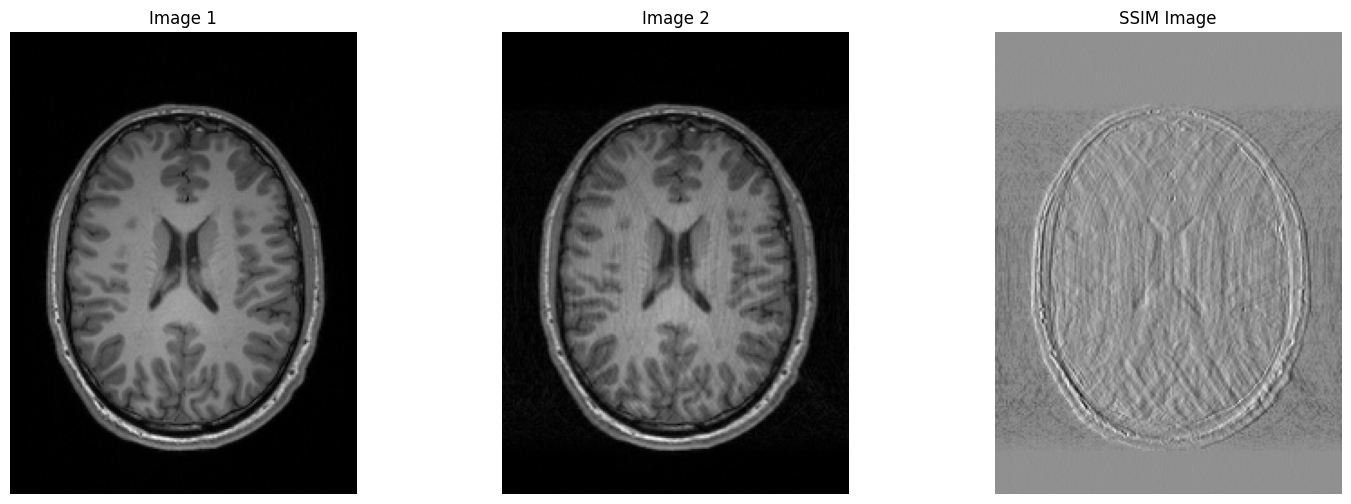

In [5]:
from skimage.metrics import structural_similarity as ssim
from skimage import io, color


# Calculate the data range
data_range = image.max() - image.min()
ssim_index, ssim_image = ssim(image, inverse_fourier_corrupted, full=True,data_range=data_range,win_size=5,sigma=0.1,K1=0.005,K2=0.005)

# Print the SSIM index
print(f'SSIM index: {ssim_index}')

# Display the original images and the SSIM image
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('Image 1')
ax[0].axis('off')

ax[1].imshow(inverse_fourier_corrupted, cmap='gray')
ax[1].set_title('Image 2')
ax[1].axis('off')

ax[2].imshow(image-inverse_fourier_corrupted, cmap='gray')
ax[2].set_title('SSIM Image')
ax[2].axis('off')


# Canny Edge Detector

(-0.5, 191.5, 255.5, -0.5)

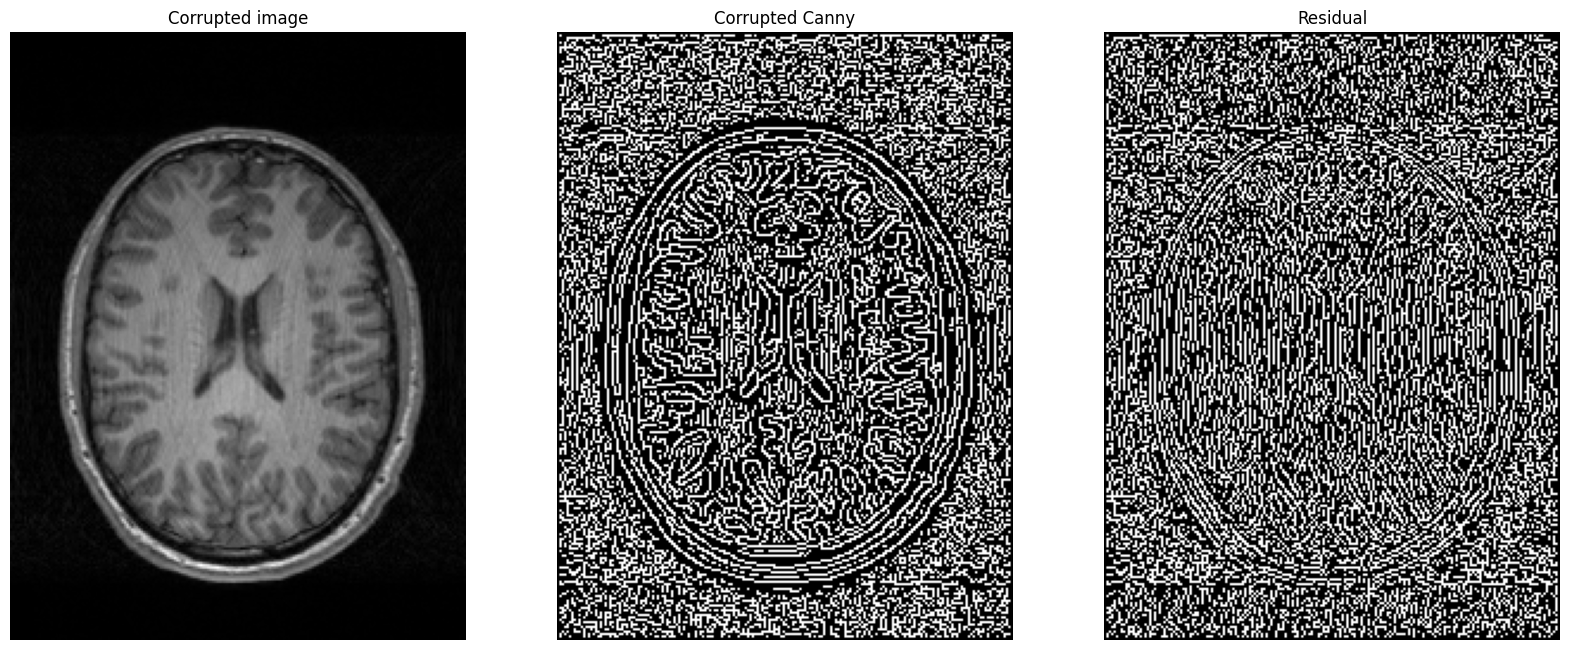

In [6]:
from skimage.feature import canny

sigma = 0
low_threshold = -10
high_threshold = -0.1

residual = image-inverse_fourier_corrupted

edges1 = np.array(canny(inverse_fourier_corrupted, sigma=sigma,low_threshold=low_threshold, high_threshold=high_threshold)).astype(int)
edges2 = np.array(canny(residual,sigma=sigma,low_threshold=low_threshold, high_threshold=high_threshold)).astype(int)
# residual = edges1-edges2


# Display the original image and the edge-detected image
fig, ax = plt.subplots(1, 3, figsize=(20, 10))


ax[0].imshow(inverse_fourier_corrupted, cmap='gray')
ax[0].set_title('Corrupted image')
ax[0].axis('off')

ax[1].imshow(edges1, cmap='gray')
ax[1].set_title('Corrupted Canny')
ax[1].axis('off')

ax[2].imshow(edges2, cmap='gray')
ax[2].set_title('Residual')
ax[2].axis('off')